In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_across_time_bins_vhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [7]:
expo_animals = '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'
pre_animals =  '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'
post_animals = '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'
post_hiatus_animals = '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'

In [8]:
delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

In [9]:
sessions = 'expo','pre','post','post_hiatus'

In [10]:
for tb in '1s',:
    for sess in sessions:
        try:
            exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,tb,sess,sess))
            exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                             '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,sess,sess))
        except:
            print 'nope %s %s'%(tb,sess)

In [11]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

In [12]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [13]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [14]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [15]:
def combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns_train.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns_train.copy()
    labels_t = labels.copy()
    for ani in patterns_train.keys():
        patterns_t[ani] = patterns_train[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns_test.copy()
        labels_T = labels.copy()
        for ani in patterns_test.keys():
            patterns_T[ani] = patterns_test[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_across_tbs(patterns_train, patterns_test, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

In [16]:
comparisons = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
relabels = [{1:0,2:0,3:1,4:1},{1:0,2:1,3:-1,4:-1},{1:-1,2:-1,3:0,4:1},{1:0,2:-1,3:1,4:-1},{1:0,2:-1,3:-1,4:1},{1:-1,2:0,3:1,4:-1},{1:-1,2:0,3:-1,4:1}]
comp_labels = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-']
comp_colors = ['r','dodgerblue','limegreen', '#7201a8', '#bd3786', '#ed7953', '#fdca26']
tt_colors = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','dodgerblue']
tt_colors_k = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','k']
alt_comparisons = ['CSPvsCSM_averaged','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
alt_colors=['#003f5c','#bc5090','#ffa600']
alt2_colors=['#15345c','#90488b','#ff6072']

In [17]:
dark_co = ('forestgreen','darkcyan','firebrick','goldenrod')

In [18]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [19]:
for sess in sessions:
        for t in range(16):
            exec('patterns_tb_%s_%s = {}'%(t,sess))
            for ani in eval('%s_animals'%sess):
                try:
                    #print sess, tb, ani,
                    exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
                except:
                    print 'NOPE',sess, tb, ani
                    continue

In [20]:
gmin=282

### running the cell below will take over an hour!

In [21]:
%%time
n_loops=20
for t in range (16):
    print t,
    for c in range (16):
        for comp,relab in zip(comparisons,relabels):
            exec('scores_tb_%s_VS_%s_%s = {}'%(t,c,comp))
            for sess in sessions:
                eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=282, relabel=relab) for i in range(n_loops)]]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 2h 58min 13s, sys: 2min 19s, total: 3h 33s
Wall time: 3h 18s



In [22]:
for t in range(16):
    for c in range(16):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4[sess],scores_tb_%s_VS_%s_CS2vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

In [23]:
comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

In [24]:
for t in range(16):
    for comp in comparisons_av:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range(16):
        for comp in comparisons_av:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range(16):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess].mean()))

In [25]:
#for t in range(16):
#    exec('distinct%s_%s_ttest = {}'%(t,comp))
#for sess in sessions:
#    for t in range(16):
#        exec("distinct%s_%s_ttest['%s'] = []"%(t,sess))
#        for c in range(16):
#            eval('distinct%s_%s_ttest'%t)[sess].insert(c,
#                (sstats.ttest_1samp(eval('scores_gmin_tb_distinct_%s_VS_%s[sess].mean(1)[:15]'%(t,c)),.5)))
#        for x,i in zip(eval('distinct%s_%s_ttest'%t)[sess],range(len(eval('distinct%s_%s_ttest'%t)[sess]))):
#            exec("distinct%s_%s_ttest[sess][i] = x[-1]"%(t)) #only take p-values

In [26]:
for t in range(16):
    for comp in comparisons_av:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range(16):
        for comp in comparisons_av:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range(16):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [27]:
for comp in comparisons_av:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

In [28]:
for comp in comparisons_av:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

In [29]:
session_labels = ('Baseline','Early','Late','Post')

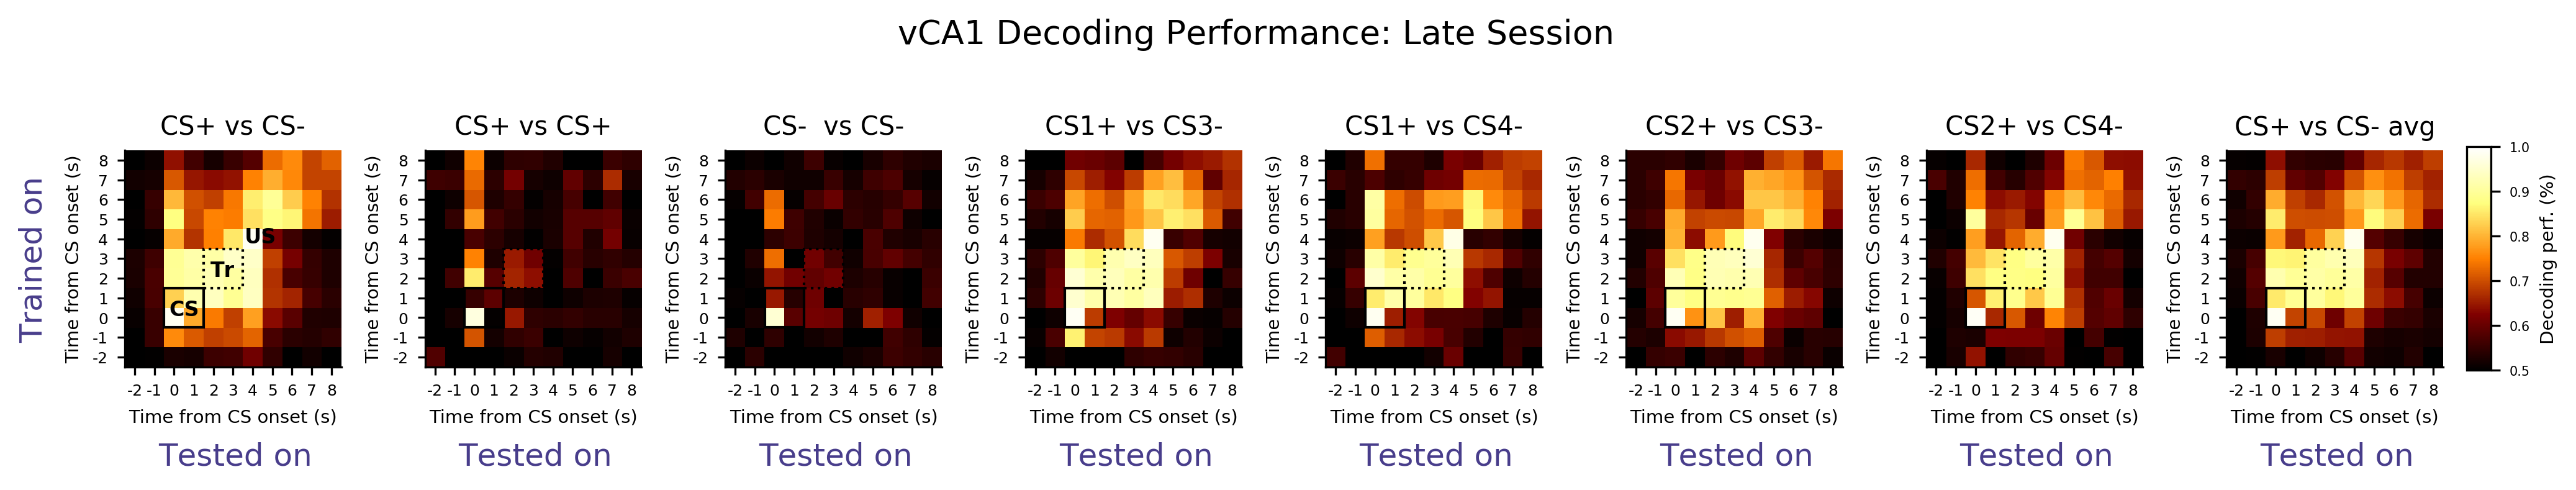

In [32]:
fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('vCA1 Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_across_bins_LATE.jpg'%NOTEBOOK_NAME)

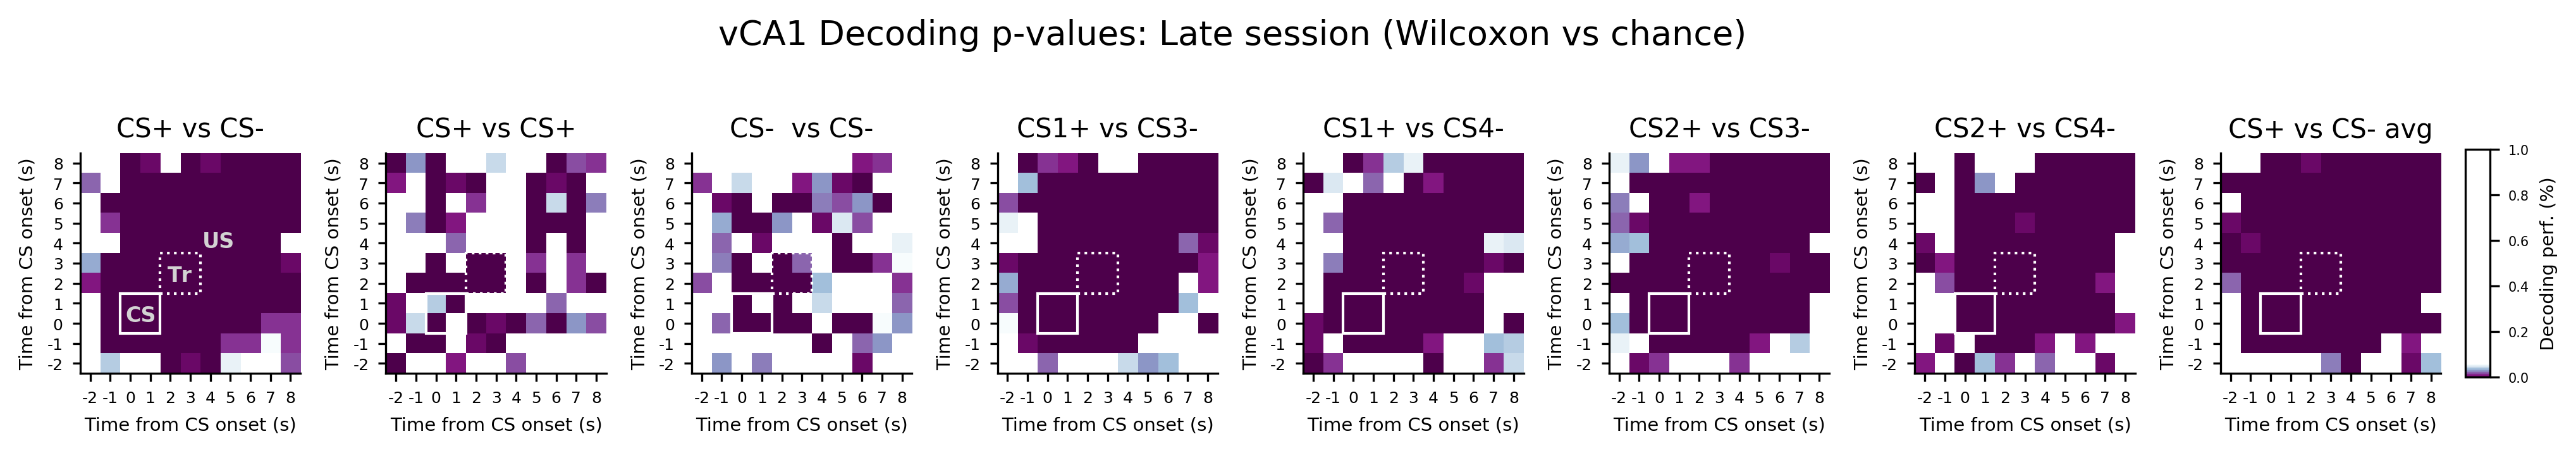

In [33]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('vCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

## Now reciprocally train/test on 2 time bins

In [34]:
def do_test_across_tbs_bothWays(patterns_train, patterns_test, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, **args)
    decoder.fit(x, y)
    scores = decoder.score(xT, yT)
    decoder.fit(xT, yT)
    return np.append(scores, decoder.score(x,y))

In [35]:
%%time
n_loops=20
for t in range(16):
    for c in range(16):
        for comp,relab in zip(comparisons,relabels):
            exec('scores_tb_%s_VS_%s_%s_bothWays = {}'%(t,c,comp))
            for sess in sessions:
                print sess,t,c,comp,
                print " ",
                eval('scores_tb_%s_VS_%s_%s_bothWays'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs_bothWays(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=282, relabel=relab) for i in range(n_loops)]]

expo 0 0 CSPvsCSM   pre 0 0 CSPvsCSM   post 0 0 CSPvsCSM   post_hiatus 0 0 CSPvsCSM   expo 0 0 CS1vsCS2   pre 0 0 CS1vsCS2   post 0 0 CS1vsCS2   post_hiatus 0 0 CS1vsCS2   expo 0 0 CS3vsCS4   pre 0 0 CS3vsCS4   post 0 0 CS3vsCS4   post_hiatus 0 0 CS3vsCS4   expo 0 0 CS1vsCS3   pre 0 0 CS1vsCS3   post 0 0 CS1vsCS3   post_hiatus 0 0 CS1vsCS3   expo 0 0 CS1vsCS4   pre 0 0 CS1vsCS4   post 0 0 CS1vsCS4   post_hiatus 0 0 CS1vsCS4   expo 0 0 CS2vsCS3   pre 0 0 CS2vsCS3   post 0 0 CS2vsCS3   post_hiatus 0 0 CS2vsCS3   expo 0 0 CS2vsCS4   pre 0 0 CS2vsCS4   post 0 0 CS2vsCS4   post_hiatus 0 0 CS2vsCS4   expo 0 1 CSPvsCSM   pre 0 1 CSPvsCSM   post 0 1 CSPvsCSM   post_hiatus 0 1 CSPvsCSM   expo 0 1 CS1vsCS2   pre 0 1 CS1vsCS2   post 0 1 CS1vsCS2   post_hiatus 0 1 CS1vsCS2   expo 0 1 CS3vsCS4   pre 0 1 CS3vsCS4   post 0 1 CS3vsCS4   post_hiatus 0 1 CS3vsCS4   expo 0 1 CS1vsCS3   pre 0 1 CS1vsCS3   post 0 1 CS1vsCS3   post_hiatus 0 1 CS1vsCS3   expo 0 1 CS1vsCS4   pre 0 1 CS1vsCS4   post 0 1 CS1vsC

In [49]:
#for outcome endoding, average each idividual comparison
for t in range(16):
    for c in range(16):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged_bothWays = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged_bothWays[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3_bothWays[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4_bothWays[sess],scores_tb_%s_VS_%s_CS2vsCS3_bothWays[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4_bothWays[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

In [52]:
for t in range(16):
    for comp in comparisons_av:
        exec('distinct_bothWays%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range(16):
        for comp in comparisons_av:
            exec("distinct_bothWays%s_%s['%s'] = []"%(t,comp,sess))
            for c in range(16):
                eval('distinct_bothWays%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s_bothWays'%(t,c,comp))[sess].mean()))

In [53]:
for t in range(16):
    for comp in comparisons_av:
        exec('distinct_bothWays%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range(16):
        for comp in comparisons_av:
            exec("distinct_bothWays%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range(16):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s_bothWays[sess].mean(1)]"%(t,c,comp))
                eval('distinct_bothWays%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct_bothWays%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct_bothWays%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct_bothWays%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

In [54]:
for comp in comparisons_av:
    exec("distinct_bothWays_%s={}"%comp)
    for sess in sessions:
        exec("distinct_bothWays_%s[sess]=(distinct_bothWays0_%s[sess], distinct_bothWays1_%s[sess], distinct_bothWays2_%s[sess], distinct_bothWays3_%s[sess], distinct_bothWays4_%s[sess], distinct_bothWays5_%s[sess], distinct_bothWays6_%s[sess], distinct_bothWays7_%s[sess],\
              distinct_bothWays8_%s[sess], distinct_bothWays9_%s[sess], distinct_bothWays10_%s[sess], distinct_bothWays11_%s[sess], distinct_bothWays12_%s[sess],\
              distinct_bothWays13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_bothWays_%s[sess]"%comp)])

In [55]:
for comp in comparisons_av:
    exec("distinct_bothWays_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_bothWays_%s_wilcox[sess]=(distinct_bothWays0_%s_wilcox[sess], distinct_bothWays1_%s_wilcox[sess], distinct_bothWays2_%s_wilcox[sess], distinct_bothWays3_%s_wilcox[sess], distinct_bothWays4_%s_wilcox[sess], distinct_bothWays5_%s_wilcox[sess], distinct_bothWays6_%s_wilcox[sess], distinct_bothWays7_%s_wilcox[sess],\
              distinct_bothWays8_%s_wilcox[sess], distinct_bothWays9_%s_wilcox[sess], distinct_bothWays10_%s_wilcox[sess], distinct_bothWays11_%s_wilcox[sess], distinct_bothWays12_%s_wilcox[sess],\
              distinct_bothWays13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_bothWays_%s_wilcox[sess]"%comp)])

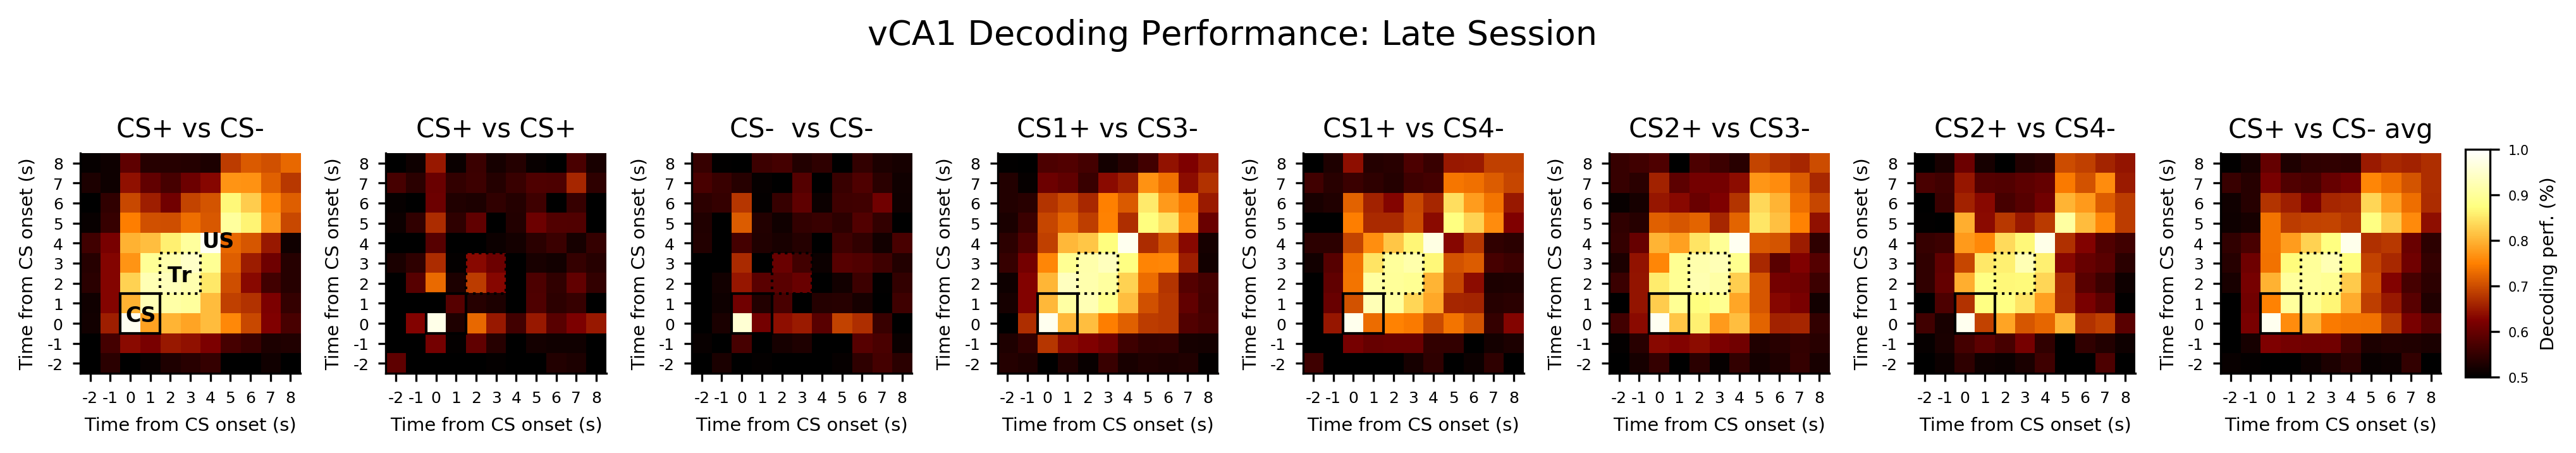

In [58]:
fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_bothWays_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    #ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

#ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('vCA1 Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_across_bins_LATE_bothWays.jpg'%NOTEBOOK_NAME)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_bothWays_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('vCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

In [57]:
save_workspace(db)

Could not store variable 'patches'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'fig'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'CS'. Skipping...
Could not store variable 'im'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'cax'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'cm'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ax'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'Tr'. Skipping...
